# 📊 Analyse Exploratoire des Données DVF

## Introduction
Ce notebook a pour objectif d'explorer les données des Demandes de Valeurs Foncières (DVF) afin de mieux comprendre la structure des transactions immobilières.

Nous allons charger les données, inspecter leur qualité, visualiser les tendances clés et identifier d'éventuelles anomalies ou valeurs aberrantes. Cette analyse est une étape essentielle avant le nettoyage et la modélisation des données.

## Étape 1 : Chargement des Bibliothèques

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Étape 2 : Chargement des Données DVF

In [2]:
# Données 1er Semestre 2024
df_2024 = pd.read_csv('https://www.data.gouv.fr/fr/datasets/r/1dc47de2-b30a-4497-b9ef-448d054b5a4f',
                 sep='|',                # Séparateur |
                 encoding='latin-1',     # Encodage pour les caractères français
                 compression='zip',      # Spécifie que c'est un fichier zip
                 low_memory=False)       # Pour éviter les warnings de memory

# Données 2023
df_2023 = pd.read_csv('https://www.data.gouv.fr/fr/datasets/r/dd516f7a-91bb-4cad-a63c-4b55cd457f4c',
                 sep='|',                # Séparateur |
                 encoding='latin-1',     # Encodage pour les caractères français
                 compression='zip',      # Spécifie que c'est un fichier zip
                 low_memory=False)       # Pour éviter les warnings de memory

# Données 2022
df_2022 = pd.read_csv('https://www.data.gouv.fr/fr/datasets/r/91fd9f09-fe6f-4ab2-9803-84a626e1faa6',
                 sep='|',                # Séparateur |
                 encoding='latin-1',     # Encodage pour les caractères français
                 compression='zip',      # Spécifie que c'est un fichier zip
                 low_memory=False)       # Pour éviter les warnings de memory

## Étape 3 : Inspection des Données

In [3]:
# Fusionner les fichiers par concaténation
liste_dfs = [df_2022, df_2023, df_2024]
df = pd.concat(liste_dfs, ignore_index=True)

In [4]:
# Filtrer uniquement les transactions du département 01
df = df[df["Code departement"] == "01"]

In [ ]:
# Export intermédiaire
df.to_csv("./ressources/df_ain.csv")

In [211]:
# Import intermédiaire
df = pd.read_csv("./ressources/df_ain.csv", low_memory=False)

In [212]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113966 entries, 0 to 113965
Data columns (total 9 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Unnamed: 0                 113966 non-null  int64  
 1   Date mutation              113966 non-null  object 
 2   Valeur fonciere            113343 non-null  object 
 3   Code postal                113337 non-null  float64
 4   Commune                    113966 non-null  object 
 5   Type local                 54776 non-null   object 
 6   Surface reelle bati        54620 non-null   float64
 7   Nombre pieces principales  54620 non-null   float64
 8   Surface terrain            84251 non-null   float64
dtypes: float64(4), int64(1), object(4)
memory usage: 7.8+ MB


In [213]:
df.describe()

,Unnamed: 0,Code postal,Surface reelle bati,Nombre pieces principales,Surface terrain
count,113966.000000,113337.000000,54620.000000,54620.000000,84251.000000
mean,56982.500000,1346.567388,79.296228,1.817173,2172.132271
std,32899.294726,219.140620,1284.606406,2.136040,8473.826165
min,0.000000,1000.000000,0.000000,0.000000,1.000000
25%,28491.250000,1170.000000,0.000000,0.000000,201.000000
50%,56982.500000,1300.000000,36.000000,0.000000,620.000000
75%,85473.750000,1500.000000,91.000000,4.000000,1470.000000
max,113965.000000,1990.000000,265000.000000,14.000000,734066.000000


### **Vérification des colonnes à supprimer**  

Pour répondre aux questions de l’énoncé, nous devons conserver uniquement les colonnes utiles à l’analyse des **prix, typologies de biens et dynamiques territoriales**. En analysant `df.info()`, nous confirmons que plusieurs colonnes sont **redondantes, trop spécifiques ou non pertinentes** pour notre objectif.  

### **Colonnes administratives inutiles :**  
Ces colonnes ne contribuent pas à l’analyse du marché immobilier et augmentent inutilement la taille du dataset :  
- `Unnamed: 0` → Index inutile généré lors de l'importation du fichier.  
- `Identifiant de document`, `Reference document` → Identifiants internes, non nécessaires pour les analyses globales.  

### **Colonnes juridiques :**  
- `1 Articles CGI`, `2 Articles CGI`, `3 Articles CGI`, `4 Articles CGI`, `5 Articles CGI` → Informations fiscales hors périmètre de l’étude.  

### **Colonnes cadastrales détaillées (trop granulaires) :**  
- `No disposition` → Information administrative sans impact sur les tendances du marché.  

### **Colonnes liées aux voies et adresses :**  
- `B/T/Q` → Très peu renseignée (seulement **3 265 valeurs non nulles sur 113 966 lignes**), non essentielle.  

### **Colonnes liées aux lots de copropriété :**  
- `1er lot`, `2eme lot`, `3eme lot`, `4eme lot`, `5eme lot` → Peu d’impact sur l’analyse macro-économique du marché immobilier.  
- **Explication** : Les informations sur les lots sont détaillées mais inutiles pour une vue d’ensemble du marché.  
- `Nombre de lots` peut être conservé si nous voulons observer la fragmentation des ventes immobilières.  

### **Colonnes liées aux cultures agricoles (hors périmètre) :**  
- `Nature culture`, `Nature culture speciale` → L’étude se concentre sur l’immobilier résidentiel et non sur l’exploitation agricole.  

In [214]:
## Suppression des Colonnes Inutiles
colonnes_a_supprimer = [
    "Unnamed: 0", "Identifiant de document", "Reference document", "Nature mutation",
    "1 Articles CGI", "2 Articles CGI", "3 Articles CGI", "4 Articles CGI", "5 Articles CGI", 
    "No disposition", "B/T/Q", "No Voie", "Type de voie", "Code voie", "Voie", 
    "1er lot", "2eme lot", "3eme lot", "4eme lot", "5eme lot", 
    "Nature culture", "Nature culture speciale"
]

df = df.drop(columns=colonnes_a_supprimer, errors='ignore')

In [215]:
## Suppression des Colonnes Inutiles - 2ème phase
colonnes_a_supprimer = [
    "Prefixe de section", "Section", "No plan", "No Volume",
    "Surface Carrez du 1er lot", "Surface Carrez du 2eme lot", "Surface Carrez du 3eme lot", 
    "Surface Carrez du 4eme lot", "Surface Carrez du 5eme lot", "Nombre de lots"
]

df = df.drop(columns=colonnes_a_supprimer, errors='ignore')

In [216]:
## Suppression des Colonnes Inutiles - 3ème phase
colonnes_a_supprimer = [
    "Identifiant local", "No voie"
]

df = df.drop(columns=colonnes_a_supprimer, errors='ignore')

In [217]:
## Suppression des Colonnes Inutiles - 4ème phase
colonnes_a_supprimer = [
    "Code commune", "Code departement", "Code type local"
]

df = df.drop(columns=colonnes_a_supprimer, errors='ignore')

In [218]:
# Export intermédiaire
df.to_csv("./ressources/df_ain.csv")

In [219]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113966 entries, 0 to 113965
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Date mutation              113966 non-null  object 
 1   Valeur fonciere            113343 non-null  object 
 2   Code postal                113337 non-null  float64
 3   Commune                    113966 non-null  object 
 4   Type local                 54776 non-null   object 
 5   Surface reelle bati        54620 non-null   float64
 6   Nombre pieces principales  54620 non-null   float64
 7   Surface terrain            84251 non-null   float64
dtypes: float64(4), object(4)
memory usage: 7.0+ MB


In [220]:
df.describe()

,Code postal,Surface reelle bati,Nombre pieces principales,Surface terrain
count,113337.000000,54620.000000,54620.000000,84251.000000
mean,1346.567388,79.296228,1.817173,2172.132271
std,219.140620,1284.606406,2.136040,8473.826165
min,1000.000000,0.000000,0.000000,1.000000
25%,1170.000000,0.000000,0.000000,201.000000
50%,1300.000000,36.000000,0.000000,620.000000
75%,1500.000000,91.000000,4.000000,1470.000000
max,1990.000000,265000.000000,14.000000,734066.000000


### **Première analyse du dataset après nettoyage**  

Le dataset contient désormais **113 966 transactions** après filtrage sur le **département de l'Ain**, avec une **réduction des colonnes** pour se concentrer sur les informations essentielles à l'analyse du marché immobilier.

---

### **Pertinence des colonnes pour répondre aux questions :**  

1️⃣ **Évolution des prix**  
   - `Code postal` et `Commune` → Permettent d’analyser les **prix par localisation**.  
   - `Valeur foncière` → Indispensable pour **calculer le prix moyen des transactions** et **le prix au m²**.  
   - `Surface réelle bâtie` et `Surface terrain` → Nécessaires pour **analyser l’évolution des prix selon la taille des biens**.  

2️⃣ **Typologie des biens**  
   - `Type local` → Catégorise les biens en **maisons, appartements, dépendances, locaux commerciaux**.  
   - `Nombre pièces principales` → Permet de comprendre la **répartition des types de logements** et la taille moyenne des biens vendus.  
   - `Surface réelle bâtie` et `Surface terrain` → Essentiels pour analyser la **distribution des surfaces des biens et des terrains**.  

3️⃣ **Dynamiques territoriales**  
   - `Code postal` et `Commune` → Facilitent la **cartographie des transactions et des zones de tension immobilière**.  
   - `Surface terrain` → Utile pour l’**étude des évolutions des terrains constructibles** et des biens avec jardin.  

---

### **Points d'attention :**  

- **`Valeur foncière` a encore des valeurs nulles** (**623 lignes** manquantes), à traiter pour éviter des biais dans l'analyse des prix.  
- **`Surface réelle bâtie` a une médiane de 36m²**, ce qui semble faible, probablement à cause de la présence de dépendances ou de petits biens.  
- **`Surface terrain` est très variable**, avec un maximum de **734 066 m²**, nécessitant un **traitement des valeurs aberrantes (outliers)**.  
- **`Type local` a encore 59 190 valeurs manquantes**, ce qui peut poser problème pour certaines analyses (classification des biens).

## Étape 4 : Traitement des Valeurs manquantes

In [221]:
df.isnull().sum()

Date mutation                    0
Valeur fonciere                623
Code postal                    629
Commune                          0
Type local                   59190
Surface reelle bati          59346
Nombre pieces principales    59346
Surface terrain              29715
dtype: int64

### **Préconisations pour le traitement des valeurs manquantes**  

L'analyse des valeurs nulles montre plusieurs colonnes avec des données partiellement absentes. Voici les actions recommandées pour garantir la qualité des analyses.

**🔹 1. `Valeur foncière` (623 valeurs manquantes, ~0.5%)**  
**Action :** Supprimer les lignes concernées, car cette colonne est essentielle pour l’analyse des prix.  

**🔹 2. `Code postal` (629 valeurs manquantes, ~0.5%)**  
**Action :**  
- Si possible, **récupérer le `Code postal` manquant à partir de la `Commune`** via une table de correspondance.  
- Sinon, **remplacer les `NaN` par "Inconnu"** pour éviter la perte de transactions.  

**🔹 3. `Type local` (59 190 valeurs manquantes, ~52%)**  
**Action :**  
- **Inscrire 'Terrain'** où `Type local` est NaN, cela signifie que le terrain est non bâti.  

**🔹 4. `Surface réelle bâtie` et `Nombre pièces principales` (59 346 valeurs manquantes, ~52%)**  
**Action :**  
- **Si `Type local` est "Maison", "Appartement" ou "Local industriel, commercial ou assimilé"**, **supprimer les lignes où `Surface réelle bâtie` et `Nombre pièces principales` sont NaN**, car ces informations sont essentielles pour analyser les biens bâtis.  
- **Si `Type local` est "Terrain" ou "Dépendance"**, **imputer `0`** pour `Surface réelle bâtie` et `Nombre pièces principales`, car ces types de biens ne sont pas censés avoir de surface habitable.  

**🔹 5. `Surface terrain` (29 715 valeurs manquantes, ~26%)**  
**Action :**  
- **Si `Type local` est `Appartement`**, imputer `0` car un appartement n’a pas de terrain.  
- **Pour les autres types**, les valeurs manquantes doivent être **supprimées**, car un bien non bâti sans terrain n’a pas de sens.  

**Traitement des Valeurs Foncières NaN**

**Action :** Supprimer les lignes concernées, car cette colonne est essentielle pour l’analyse des prix.

In [222]:
# Suppression des lignes où 'Valeur foncière' est NaN
df = df.dropna(subset=["Valeur fonciere"])

**Traitement des Codes postaux NaN**

In [223]:
# Afficher les communes dont le Code postal est manquant
communes_sans_cp = df[df["Code postal"].isna()][["Commune"]].drop_duplicates()

print(communes_sans_cp)

                         Commune
483             ST-GENIS-POUILLY
1831         AMBERIEUX-EN-DOMBES
5147                     LEYMENT
5923                      CROZET
7776             BOURG-EN-BRESSE
8945                   COLLONGES
15262          DIVONNE-LES-BAINS
28446                    BUELLAS
35010                 VALSERHONE
37540                    BEYNOST
37784            FERNEY-VOLTAIRE
38708        MONTMERLE-SUR-SAONE
40817        MONTREVEL-EN-BRESSE
43545                     POUGNY
46424      SAINT-DENIS-LES-BOURG
47705                        GEX
49960                     BELLEY
53040   CHATILLON-SUR-CHALARONNE
53671                    TREVOUX
68748                  BELIGNEUX
75439                      ORNEX
80169         ST-GERMAIN-DE-JOUX
87749                  VERSONNEX
91661    SAINT-LAURENT-SUR-SAONE
93180                    MIONNAY
95385                     NANTUA
100640                   DAGNEUX


In [224]:
# Dictionnaire des codes postaux pour les communes manquantes
codes_postaux_manquants = {
    "ST-GENIS-POUILLY": 1630, "AMBERIEUX-EN-DOMBES": 1330, "LEYMENT": 1150, "CROZET": 1170,
    "BOURG-EN-BRESSE": 1000, "COLLONGES": 1550, "DIVONNE-LES-BAINS": 1220, "BUELLAS": 1310,
    "VALSERHONE": 1200, "BEYNOST": 1700, "FERNEY-VOLTAIRE": 1210, "MONTMERLE-SUR-SAONE": 1090,
    "MONTREVEL-EN-BRESSE": 1340, "POUGNY": 1550, "SAINT-DENIS-LES-BOURG": 1000, "GEX": 1170,
    "BELLEY": 1300, "CHATILLON-SUR-CHALARONNE": 1400, "TREVOUX": 1600, "BELIGNEUX": 1360,
    "ORNEX": 1210, "ST-GERMAIN-DE-JOUX": 1130, "VERSONNEX": 1210,
    "SAINT-LAURENT-SUR-SAONE": 1750, "MIONNAY": 1390, "NANTUA": 1130, "DAGNEUX": 1120
}

# Remplacement des valeurs NaN 
df["Code postal"] = df["Code postal"].fillna(df["Commune"].map(codes_postaux_manquants))

In [225]:
# Convertir Code postal en string de 5 chiffres
df["Code postal"] = df["Code postal"].astype("Int64").astype(str).str.zfill(5)

In [226]:
df["Code postal"].isnull().sum()

0

**Colonne Type local**

In [227]:
# Remplacer les NaN dans "Type local" par "Terrain"
df["Type local"] = df["Type local"].fillna("Terrain")

**Colonnes 'Surface réelle bâtie' et 'Nombre pièces principales'**

In [228]:
# Supprimer les lignes où "Surface réelle bâtie" et "Nombre pièces principales" sont NaN pour les biens bâtis
df = df[~(df["Type local"].isin(["Maison", "Appartement", "Local industriel. commercial ou assimilÃ©"]) & 
          (df["Surface reelle bati"].isna() | df["Nombre pieces principales"].isna()))]

# Imputer 0 pour les terrains et dépendances
df.loc[df["Type local"].isin(["Terrain", "DÃ©pendance"]), ["Surface reelle bati", "Nombre pieces principales"]] = 0

In [229]:
# Vérification
df.isnull().sum()

Date mutation                    0
Valeur fonciere                  0
Code postal                      0
Commune                          0
Type local                       0
Surface reelle bati              0
Nombre pieces principales        0
Surface terrain              29698
dtype: int64

**Colonne Surface Terrain**

**Action :**  
- **Si `Type local` est `Appartement`**, imputer `0` car un appartement n’a pas de terrain.  
- **Pour les autres types**, les valeurs manquantes doivent être **supprimées**, car un bien non bâti sans terrain n’a pas de sens.

In [230]:
# Imputer 0 pour les Appartements car ils n'ont pas de terrain
df.loc[df["Type local"] == "Appartement", "Surface terrain"] = df["Surface terrain"].fillna(0)

# Supprimer les lignes où "Surface terrain" est NaN pour les autres types de biens
df = df.dropna(subset=["Surface terrain"])

## Étape 5 : Traitement des Valeurs aberrantes

**Colonne Valeur Foncière**

In [231]:
df["Valeur fonciere"].value_counts()

Valeur fonciere
1,00         1787
150000,00     781
200000,00     755
120000,00     680
180000,00     655
             ... 
87250,00        1
451450,00       1
146900,00       1
122,25          1
85400,00        1
Name: count, Length: 8344, dtype: int64

La colonne Valeur foncière contient des valeurs extrêmes qui peuvent fausser l’analyse du marché immobilier. Nous allons identifier et traiter ces outliers en utilisant la méthode des quartiles (IQR - Interquartile Range).

In [232]:
# Remplacer les virgules par des points et convertir en float
df["Valeur fonciere"] = df["Valeur fonciere"].str.replace(",", ".").astype(float)

# Calcul des quartiles
Q1 = df["Valeur fonciere"].quantile(0.25)
Q3 = df["Valeur fonciere"].quantile(0.75)

# Calcul de l'IQR (écart interquartile)
IQR = Q3 - Q1

# Définition des seuils pour détecter les valeurs aberrantes
borne_inf = Q1 - 1.5 * IQR
borne_sup = Q3 + 1.5 * IQR

# Suppression des valeurs extrêmes
df = df[(df["Valeur fonciere"] >= borne_inf) & (df["Valeur fonciere"] <= borne_sup)]

In [233]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86572 entries, 0 to 113965
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date mutation              86572 non-null  object 
 1   Valeur fonciere            86572 non-null  float64
 2   Code postal                86572 non-null  object 
 3   Commune                    86572 non-null  object 
 4   Type local                 86572 non-null  object 
 5   Surface reelle bati        86572 non-null  float64
 6   Nombre pieces principales  86572 non-null  float64
 7   Surface terrain            86572 non-null  float64
dtypes: float64(4), object(4)
memory usage: 5.9+ MB


**Vérification des autres valeurs aberrantes**

In [234]:
df.describe()

,Valeur fonciere,Surface reelle bati,Nombre pieces principales,Surface terrain
count,86572.000000,86572.000000,86572.000000,86572.000000
mean,185470.370044,35.079275,1.034122,1862.270665
std,175392.141646,379.946222,1.822763,6585.896511
min,0.210000,0.000000,0.000000,0.000000
25%,22000.000000,0.000000,0.000000,114.000000
50%,150000.000000,0.000000,0.000000,506.000000
75%,285500.000000,52.000000,2.000000,1265.000000
max,755000.000000,77432.000000,14.000000,266910.000000


| **Colonne**                | **Min**  | **Q1 (25%)** | **Q2 (Médiane)** | **Q3 (75%)** | **Max**   | **Observation** |
|----------------------------|---------|--------------|------------------|--------------|---------|--------------|
| **Surface réelle bâtie**   | 0.00    | 0.00         | 0.00             | 52.00        | 77 432  | ⚠ **Outliers potentiels** (Max très élevé) |
| **Nombre pièces principales** | 0.00 | 0.00         | 0.00             | 2.00         | 14.00   | ⚠ **Vérifier les biens à 0 pièce** |
| **Surface terrain**        | 0.00    | 114.00       | 506.00           | 1 265.00     | 266 910 | ⚠ **Outliers potentiels** (Max très élevé) |

**Colonne Surface réelle bâtie**

- **Médiane = 0 m²**, cela signifie que beaucoup de transactions concernent des **terrains** ou **dépendances sans surface bâtie**.  
- **Q3 = 52 m²**, mais **le max est à 77 432 m²**, ce qui est extrêmement élevé.  
- Il faut **plafonner les valeurs extrêmes** pour éviter la perte d'informations, pour réduire également l'impact de ces valeurs aberrantes.

In [235]:
# bornes des outliers
Q1 = df["Surface reelle bati"].quantile(0.25)
Q3 = df["Surface reelle bati"].quantile(0.75)
IQR = Q3 - Q1

# Définition du seuil
borne_sup = df["Surface reelle bati"].quantile(0.99)  # Seuil à 99%

# Supprimer les valeurs extrêmes
df = df[df["Surface reelle bati"] <= borne_sup]

**Colonne Surface Terrain**

- **Médiane = 506 m²**, ce qui est cohérent avec des parcelles de maisons individuelles.  
- **Max = 266 910 m²**, ce qui est probablement un **grand terrain agricole ou une valeur aberrante**.  
- **Q3 = 1 265 m²**, donc la majorité des terrains ne dépassent pas 1 300 m².
- **Solution** : Appliquer l’IQR et plafonner les valeurs extrêmes*

In [236]:
# bornes des outliers
Q1 = df["Surface terrain"].quantile(0.25)
Q3 = df["Surface terrain"].quantile(0.75)
IQR = Q3 - Q1

# Définition du seuil
borne_sup = df["Surface terrain"].quantile(0.99)  # Seuil à 99%

# Supprimer les valeurs extrêmes
df = df[df["Surface terrain"] <= borne_sup]

In [237]:
# Vérification
print(df["Surface terrain"].describe())

count    84854.000000
mean      1379.047882
std       2781.446617
min          0.000000
25%        109.000000
50%        500.000000
75%       1200.000000
max      24402.000000
Name: Surface terrain, dtype: float64


## Étape 6 : Finalisation du Nettoyage

In [238]:
# Conversion de la colonne Date Mutation en format Date
df["Date mutation"] = pd.to_datetime(df["Date mutation"], format="%d/%m/%Y").dt.date

In [239]:
# Exportation finale
df.to_csv("./ressources/df_ain_nettoye.csv")

## Étape 7 : Visualisation des Données

Après le nettoyage des données, cette section vise à **explorer visuellement les dynamiques du marché immobilier dans le département de l'Ain**.  

L'objectif est de structurer les visualisations en fonction des **grandes thématiques** du business case afin de commencer à répondre aux questions clés posées par la DDT :  

- **Évolution des prix** : Observer les tendances des prix moyens, le prix au m² et l’évolution des transactions au fil du temps.  
- **Typologie des biens** : Comprendre la répartition des types de biens vendus et analyser les surfaces bâties et les terrains.  
- **Dynamiques territoriales**  : Identifier les communes les plus dynamiques et repérer les zones où les prix sont les plus élevés.  

Ces visualisations permettront d'extraire des **insights pertinents** pour alimenter le tableau de bord final et orienter les décisions des acteurs locaux.  

### 1. Evolution des Prix

#### Prix moyen par Commune

Ce graphique montre le prix moyen des transactions par commune (Top 20).  
Il permet d'identifier les communes les plus chères et d'observer les disparités territoriales.

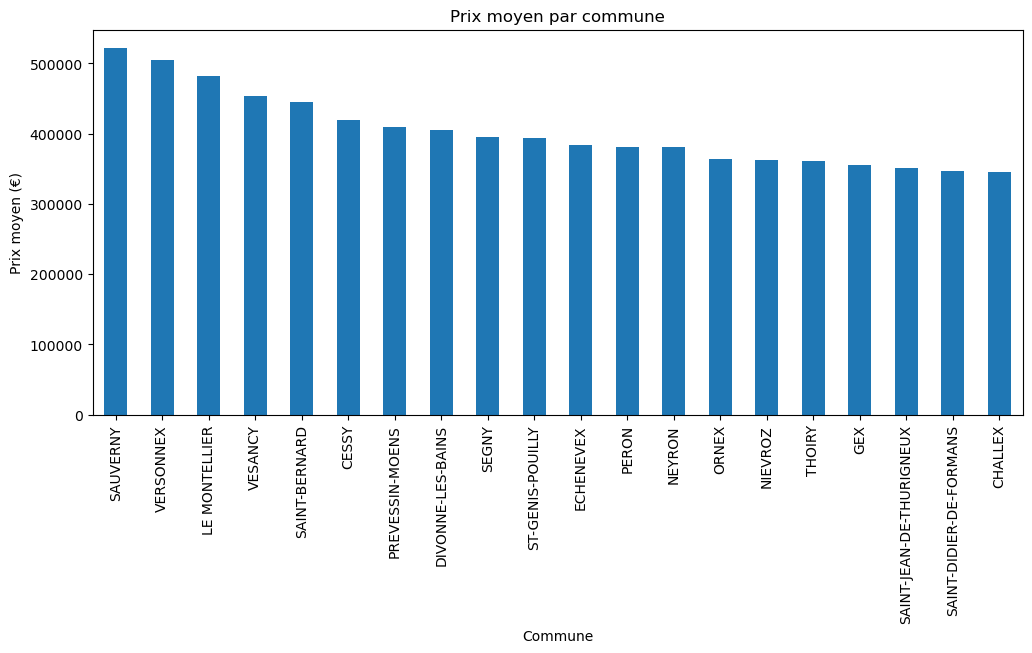

In [240]:
# Prix moyen par commune (top 20)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 5))
prix_commune = df.groupby("Commune")["Valeur fonciere"].mean().sort_values(ascending=False).head(20)
prix_commune.plot(kind="bar", ax=ax, title="Prix moyen par commune")
ax.set_ylabel("Prix moyen (€)")
ax.set_xticklabels(prix_commune.index, rotation=90)
plt.show()

#### Prix médian au m² par type de bien 

Ce graphique compare le prix médian au m² par type de bien (Maison, Appartement, Local, Terrain).


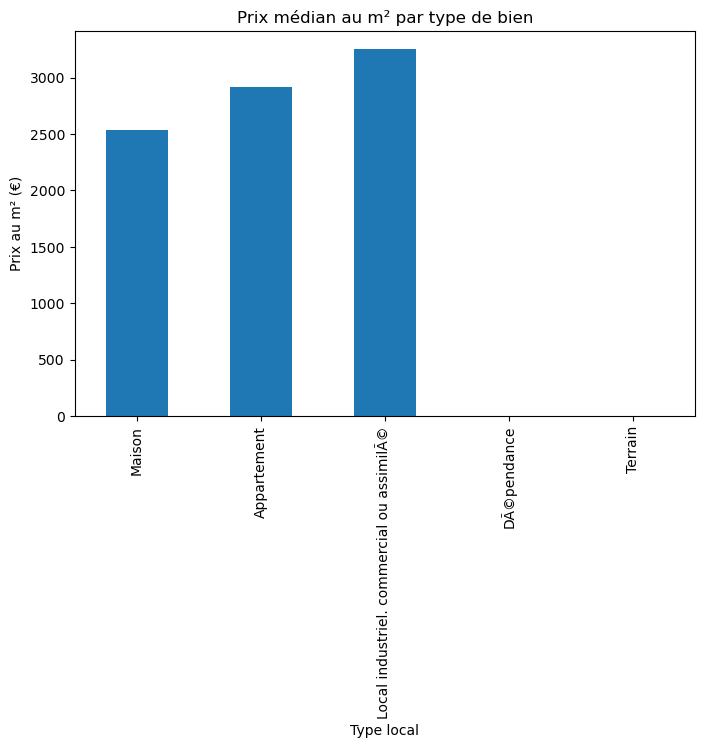

In [241]:
# Calcul du prix au m²
df["Prix_m2"] = df["Valeur fonciere"] / df["Surface reelle bati"]

# Prix médian au m² par type de bien
fig, ax = plt.subplots(figsize=(8, 5))
prix_m2_type = df.groupby("Type local")["Prix_m2"].median().sort_values()
prix_m2_type.plot(kind="bar", ax=ax, title="Prix médian au m² par type de bien")
ax.set_ylabel("Prix au m² (€)")
plt.show()

#### Évolution des transactions au fil du temps  
Ce graphique montre l'évolution du volume de transactions immobilières sur les trois dernières années.

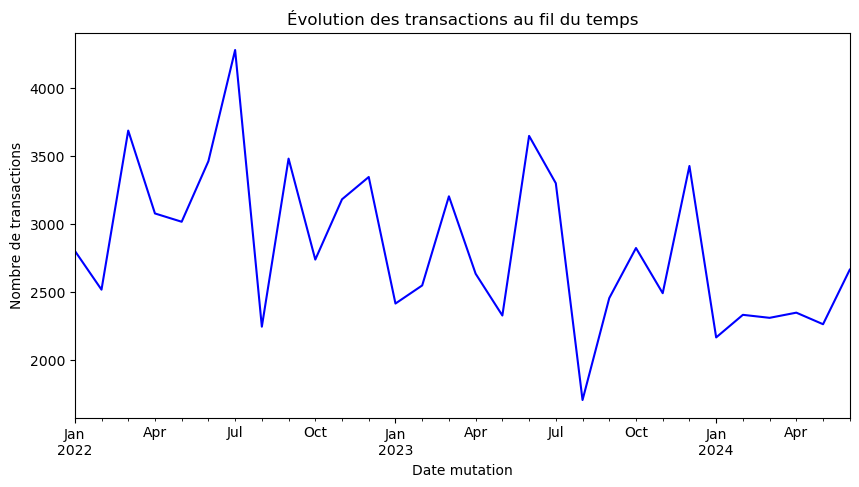

In [242]:
# Convertir "Date mutation" en format datetime
df["Date mutation"] = pd.to_datetime(df["Date mutation"])

# Agrégation mensuelle des transactions
fig, ax = plt.subplots(figsize=(10, 5))
transactions_temps = df.resample("ME", on="Date mutation").size()
transactions_temps.plot(ax=ax, title="Évolution des transactions au fil du temps", color="blue")
ax.set_ylabel("Nombre de transactions")
plt.show()

### 2. Typologie des Biens

#### Répartition des types de biens 

Ce graphique illustre la répartition des transactions par type de bien (Maison, Appartement, Local...).


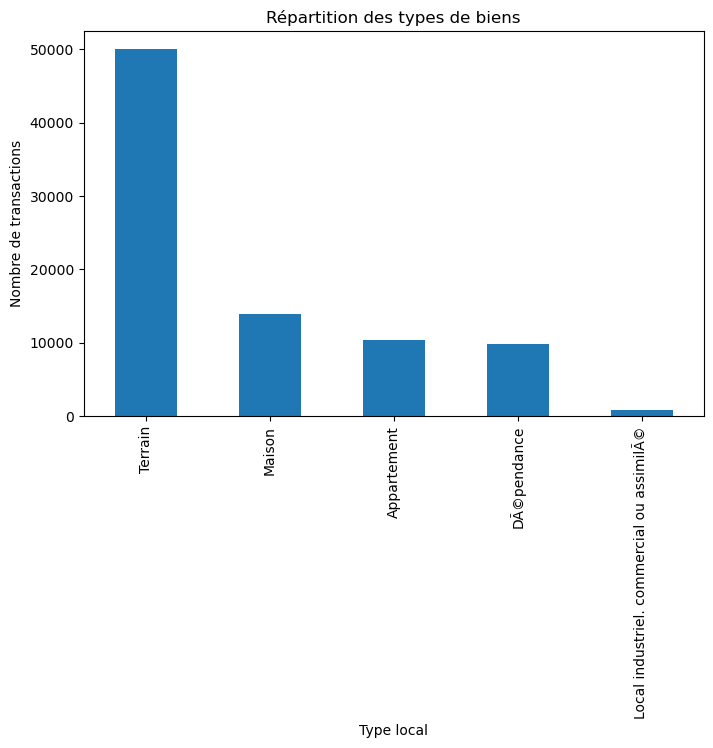

In [243]:
# Répartition des types de biens
fig, ax = plt.subplots(figsize=(8, 5))
df["Type local"].value_counts().plot(kind="bar", ax=ax, title="Répartition des types de biens")
ax.set_ylabel("Nombre de transactions")
plt.show()

#### Distribution des surfaces bâties 

Ce graphique montre la distribution des surfaces bâties pour les biens immobiliers vendus.

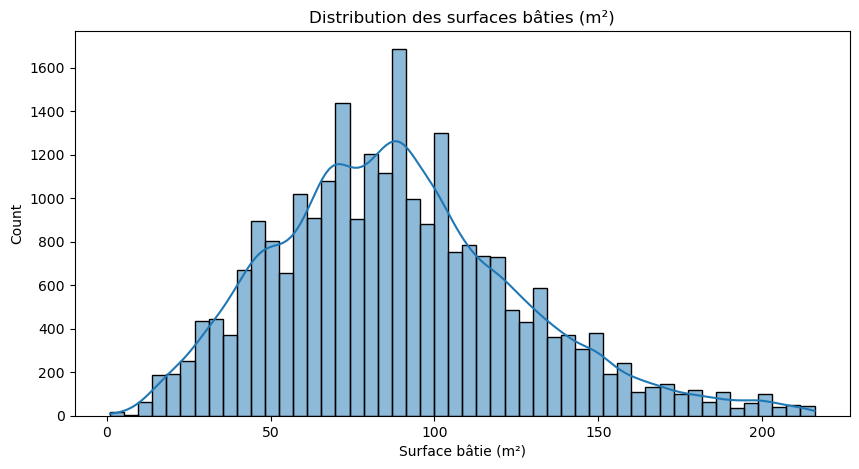

In [244]:
# Distribution des surfaces bâties
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(df[df["Surface reelle bati"] > 0]["Surface reelle bati"], bins=50, kde=True, ax=ax)
ax.set_title("Distribution des surfaces bâties (m²)")
ax.set_xlabel("Surface bâtie (m²)")
plt.show()

#### Distribution des surfaces des terrains  

Ce graphique montre la distribution des surfaces des terrains vendus.


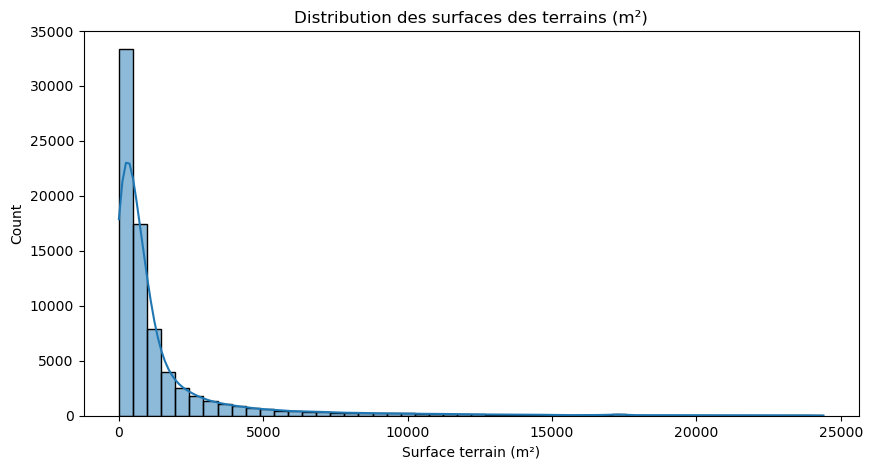

In [245]:
# Distribution des surfaces des terrains
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(df[df["Surface terrain"] > 0]["Surface terrain"], bins=50, kde=True, ax=ax)
ax.set_title("Distribution des surfaces des terrains (m²)")
ax.set_xlabel("Surface terrain (m²)")
plt.show()

### 3. Dynamiques Territoriales

####  Nombre de transactions par commune 

Ce graphique montre les 20 communes où il y a eu le plus de transactions immobilières.

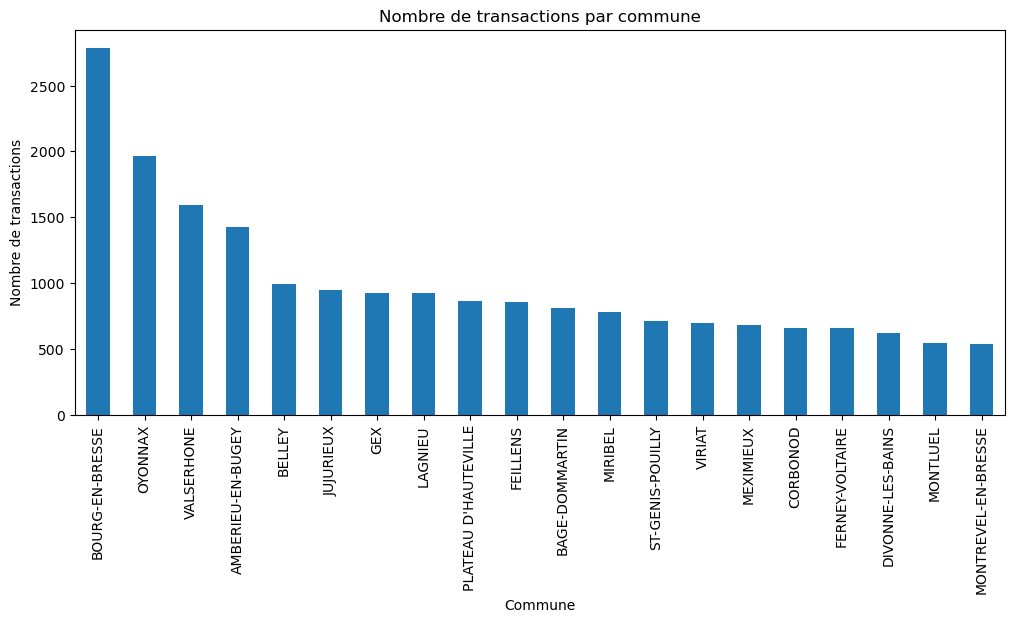

In [246]:
# Nombre de transactions par commune (top 20)
fig, ax = plt.subplots(figsize=(12, 5))
transactions_commune = df["Commune"].value_counts().head(20)
transactions_commune.plot(kind="bar", ax=ax, title="Nombre de transactions par commune")
ax.set_ylabel("Nombre de transactions")
ax.set_xticklabels(transactions_commune.index, rotation=90)
plt.show()

#### Prix moyen des transactions par commune  
Ce graphique montre les 20 communes où les prix moyens des transactions sont les plus élevés.

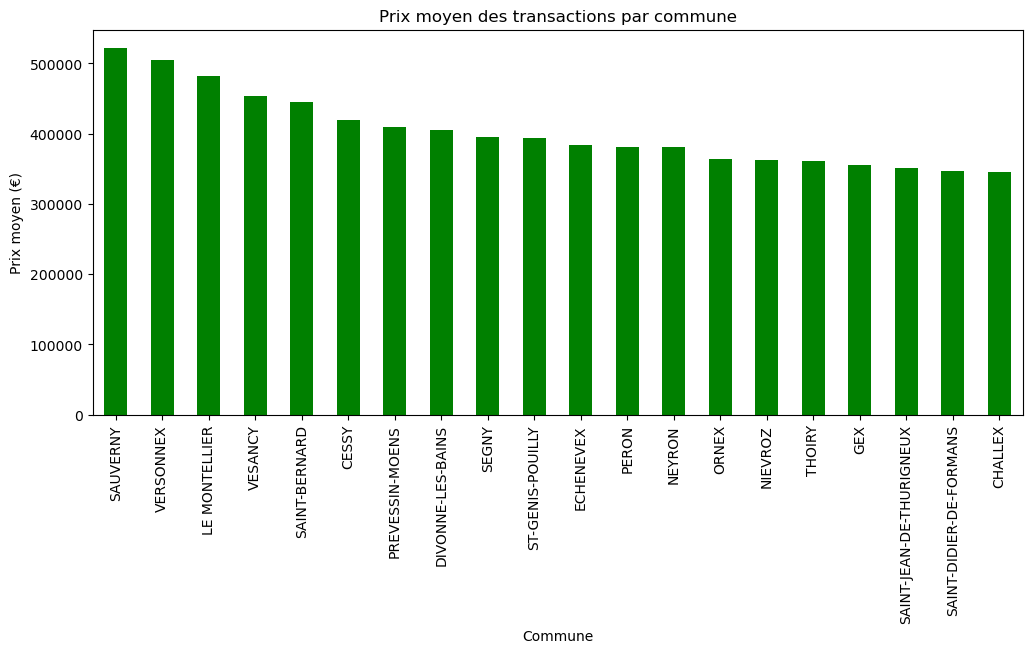

In [247]:
# Prix moyen des transactions par commune (top 20)
fig, ax = plt.subplots(figsize=(12, 5))
prix_commune = df.groupby("Commune")["Valeur fonciere"].mean().sort_values(ascending=False).head(20)
prix_commune.plot(kind="bar", ax=ax, title="Prix moyen des transactions par commune", color="green")
ax.set_ylabel("Prix moyen (€)")
ax.set_xticklabels(prix_commune.index, rotation=90)
plt.show()

## Synthèse des Analyses et Recommandations

Après avoir exploré visuellement les données, voici les **insights majeurs** concernant le marché immobilier dans le département de l'Ain.

### **Évolution des prix** 

#### 🔹 **Quels sont les prix moyens par commune ?**  
- Les communes avec les **prix moyens les plus élevés** sont **Sauverny, Versonnex et Le Montellier** avec des valeurs dépassant les **450 000 € en moyenne**.  
- Cela peut s’expliquer par la **proximité avec Genève**, un effet connu du marché immobilier frontalier, où les prix sont tirés vers le haut par la demande suisse.  

#### 🔹 **Comment évolue le prix au m² selon le type de bien ?**  
- **Les locaux commerciaux sont les plus chers**, avec un prix médian au m² supérieur à **3 200 €/m²**.  
- **Les appartements affichent environ 2 900 €/m²**, suivis des maisons autour de **2 500 €/m²**.  
- **Les terrains** ne sont pas affichés ici en termes de prix au m², car leur valeur dépend fortement des caractéristiques cadastrales et des PLU locaux.  

#### 🔹 **Quelle est la tendance des transactions au fil du temps ?**  
- On observe une **saisonnalité** dans les transactions avec des **pics en été et en fin d’année**.  
- Le **volume des transactions fluctue fortement** d’un mois sur l’autre, possiblement influencé par la **conjoncture économique et les taux d’intérêt**.

---

### **Typologie des biens**  

#### 🔹 **Quelle est la répartition des types de biens vendus ?**  
- **Les terrains dominent le marché** en nombre de transactions, suivis des maisons et appartements.  
- Cela **confirme une dynamique de construction**, notamment dans les zones périurbaines.  
- **Les dépendances sont nombreuses**, ce qui peut refléter des ventes de biens annexes ou agricoles.  

#### 🔹 **Comment se distribuent les surfaces des biens bâtis ?**  
- La **majorité des logements vendus** ont une **surface comprise entre 50 et 150 m²**.  
- Une **concentration importante autour de 100 m²** indique que la plupart des transactions concernent des maisons individuelles de taille standard.  

#### 🔹 **Comment se distribuent les surfaces des terrains ?**  
- **Beaucoup de petites parcelles (< 500 m²)** sont observées, indiquant des divisions foncières ou des ventes de terrains constructibles.  
- Des **pics sont encore visibles sur les grandes surfaces**, ce qui nécessiterait une analyse plus fine pour différencier les terrains agricoles des parcelles à bâtir.  

---

### **Dynamiques territoriales**  

#### 🔹 **Quelles sont les communes les plus dynamiques en termes de transactions ?**  
- **Bourg-en-Bresse, Oyonnax et Valserhône** sont les villes où le **nombre de transactions est le plus élevé**.  
- Ces villes concentrent une forte **activité immobilière**, avec une **demande élevée en logement** due à leur attractivité économique et leur localisation stratégique.  

#### 🔹 **Existe-t-il des disparités significatives entre les secteurs ?**  
- **Les zones proches de la frontière suisse** affichent des **prix nettement supérieurs** au reste du département.  
- **Les prix sont plus modérés dans le Bugey et la Dombes**, mais la dynamique de transactions y est plus élevée, indiquant des secteurs en développement.  

---

## **Conclusions et Recommandations**  

✔ **L’effet frontière est un facteur majeur de tension sur les prix.** Les communes proches de Genève ont des prix moyens **nettement supérieurs** à celles situées plus au centre du département.  
✔ **Le marché des terrains est particulièrement actif**, ce qui suggère un potentiel important de **nouvelles constructions et d’aménagements fonciers**.  
✔ **Les volumes de transactions fluctuent fortement**, ce qui nécessite un suivi régulier pour identifier les **cycles du marché**.  
